# **Confusion Matrices**
> This notebook focuses on the concepts of _imbalanced datasets_ and _confusion matrices_

## Load the data
> The dataset in this exercise contains different classes of objects found in the snow, based on drone sensor data. The objects' features include `size`, `roughness`, `color` and `motion`

> As is the norm, the dataset has to be loaded to be analysed

In [ ]:
import pandas as pd
!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/snow_objects.csv

dataset = pd.read_csv('snow_objects.csv', delimiter='\t')

In [ ]:
# dataset info
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   size       2200 non-null   float64
 1   roughness  2200 non-null   float64
 2   color      2200 non-null   object 
 3   motion     2200 non-null   float64
 4   label      2200 non-null   object 
dtypes: float64(3), object(2)
memory usage: 86.1+ KB


In [ ]:
# a little peek into the data
dataset.head()

,size,roughness,color,motion,label
0,50.959361,1.318226,green,0.054290,tree
1,60.008521,0.554291,brown,0.000000,tree
2,20.530772,1.097752,white,1.380464,tree
3,28.092138,0.966482,grey,0.650528,tree
4,48.344211,0.799093,grey,0.000000,tree


## Data exploration
> The dataset contains both continuous numerical data and categorical data
> + Numerical data: `size`, `roughness` & `motion`
> + Categorical data: `color` & `label`

### Exploring `label` distribution
> Since the `label` column contains categorical data, the `value_counts` for each label class will be used to visualize distribution in a [`bar`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html) graph

In [ ]:
# value_counts for each label class
dataset['label'].value_counts().sort_values()

label
animal    200
hiker     400
tree      800
rock      800
Name: count, dtype: int64

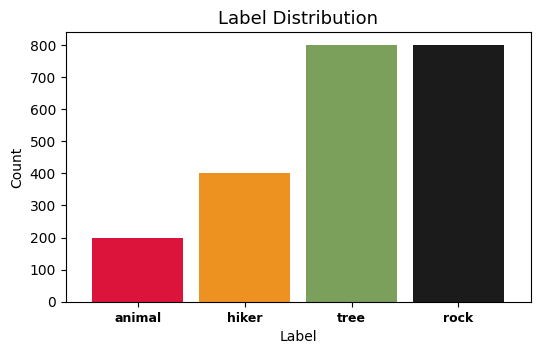

In [ ]:
# plotting a bar graph of that
import matplotlib.pyplot as plt
# specify stylesheet
plt.style.use('fast')

# initialize figure and axes
fig, ax = plt.subplots(figsize=(6, 3.5))
# bar plot
dataset['label'].value_counts().sort_values().plot.bar(
    ax = ax,
    color=['#DC143C', '#ED9121', '#7BA05B', '#1B1B1B'],
    width=0.85
)

# modify the plot appearance
ax.set_title('Label Distribution', fontsize=13)
ax.set_ylabel('Count', fontsize=10)
ax.set_xlabel('Label', fontsize=10)
ax.set_xticklabels(['animal', 'hiker', 'tree', 'rock'],
                   rotation=0, weight='black', fontsize=9)
plt.show()

> 💡 **Insight**
> + The dataset contains 4 label classes
> + This is an _imbalanced_ dataset: classes are not represented in the same proportion (there's 4 times more rocks and trees than animals, for instance)

### Exploring `color` distribution
> Similarly, since the `color` column contains categorical data, the `value_counts` for each `color` will be used to visualize distribution

In [ ]:
# value_counts for each color
dataset['color'].value_counts().sort_values()

color
orange     18
red        29
blue       42
black     288
green     317
grey      332
white     537
brown     637
Name: count, dtype: int64

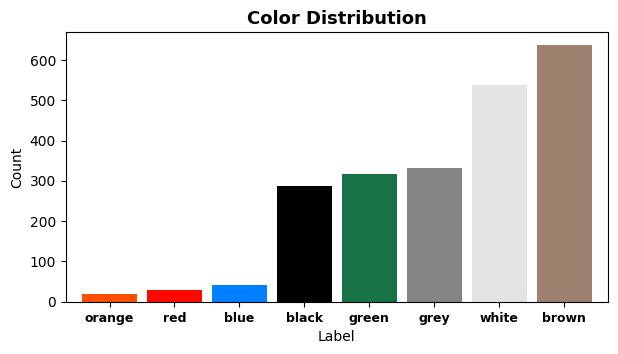

In [ ]:
color_codes = ['#FF4F00', '#FF0800', '#007FFF', '#000000', '#177245', '#848482', '#E5E4E2', '#9F8170']
color_names = ['orange', 'red', 'blue', 'black', 'green', 'grey', 'white', 'brown']
# plotting a bar graph of that

# define the figure and axes
fig, ax = plt.subplots(figsize=(7, 3.5))
# bar plot
dataset['color'].value_counts().sort_values().plot.bar(
    ax = ax,
    color = color_codes,
    width = 0.85
)

# modify plot apperance
ax.set_title('Color Distribution', weight='black', fontsize=13)
ax.set_ylabel('Count', fontsize=10)
ax.set_xlabel('Label', fontsize=10)
ax.set_xticklabels(color_names,
                   rotation=0, weight='black', fontsize=9)
plt.show()

> 💡 **Insight**
> + The dataset contains 8 distinct colors
> + The `color` feature is also heavily imbalanced

### Exploring the distribution of numerical features
> The distribution of numerical features: `size`, `roughness` & `motion` will be exlored using a [`boxplot`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html)

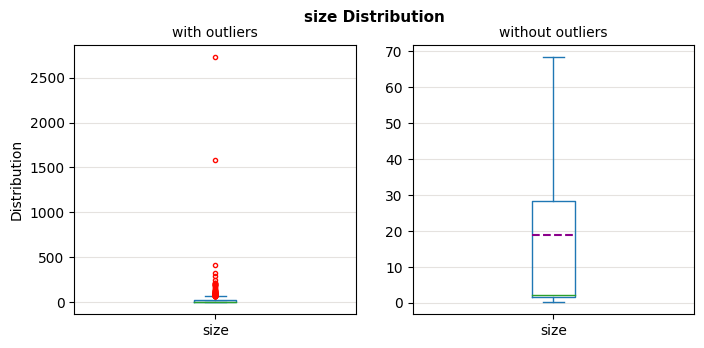

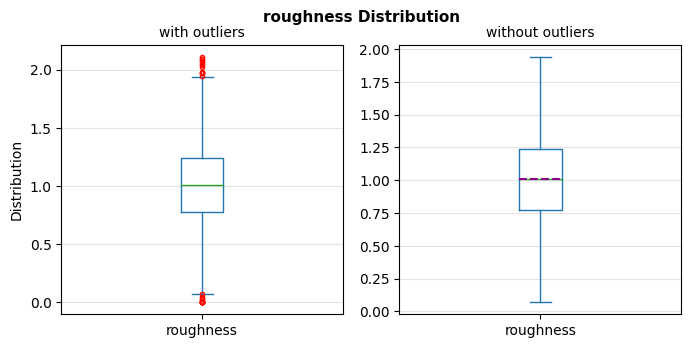

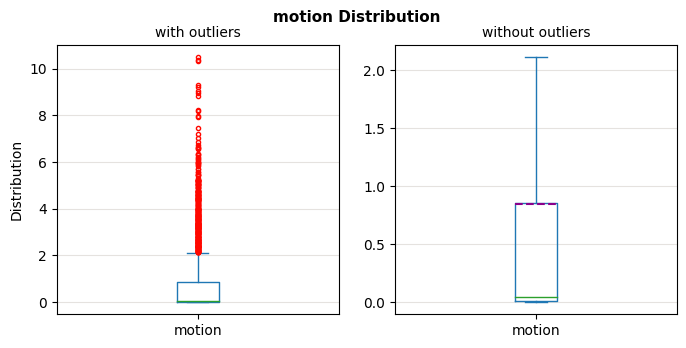

In [ ]:
# define a list with the numerical column names:
num_cols = ['size', 'roughness', 'motion']

for col in num_cols:
  # specify a subplot with 1 row & 2 columns
  fig, axs = plt.subplots(1, 2, figsize=(8, 3.5))

  # box plot 0 (with fliers):
  dataset.plot.box(
                  column=col,
                  flierprops=dict(marker='.', markeredgecolor='#FF0800'),
                  showfliers=True,
                   ax = axs[0])

  # box plot 1 (without fliers):
  dataset.plot.box(
                  column=col,
                  flierprops=dict(marker='.', markeredgecolor='#FF0800'),
                  meanprops=dict(linestyle='--', color='#8B008B', linewidth=1.5),
                  meanline=True,
                  showmeans=True,
                  showfliers=False,
                   ax = axs[1])

  # modify plot appearance
  plt.suptitle(f'{col} Distribution', weight='black', fontsize=11)
  axs[0].set_ylabel('Distribution')
  axs[0].grid(axis="y", color="#dbd7d2", alpha=0.7)
  axs[0].set_title('with outliers', fontsize=10)

  axs[1].set_title('without outliers', fontsize=10)
  axs[1].grid(axis="y", color="#dbd7d2", alpha=0.7)
  plt.show()
  print('\n')

> 💡 **Insight**
> + Majority of `size` samples with small, with samples ranging from `0` to `70`, with few bigger outliers  
> + There isn't a lot of variation in the `roughness` feature, with most values close to the mean. Values range between `0` and around `2`
> + From the `motion` boxplots, most objects seem to be either static or moving very slowly. There's a smaller number of objects moving faster, with a couple of outliers over `10`
>> It can be assumed that the smaller and faster objects are `hikers` and `animals` whereas the more static, bigger objects are likely `trees` and `rocks`

## Building a classification model
> We'll use a [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to predict the class an object belongs to

In [ ]:
# divide the dataset into X(features) and y(label)
# leave out the color column for now:
X = dataset[['size', 'roughness', 'motion']].copy()

# label
y = dataset['label']

In [ ]:
# import train_test_split
from sklearn.model_selection import train_test_split

# split the dataset into 70 / 30
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, random_state=2)

print(f'Training set size: {X_train.shape}')
print(f'Test set size: {X_test.shape}')

Training set size: (1540, 3)
Test set size: (660, 3)


> Training the model on the data

In [ ]:
%%time
# import RandomForestClassfier
from sklearn.ensemble import RandomForestClassifier

# create model
model = RandomForestClassifier(n_estimators=1,
                               random_state=1, verbose=False, n_jobs=-1)

# train
model.fit(X_train, y_train)
print("")


CPU times: user 293 ms, sys: 31.9 ms, total: 325 ms
Wall time: 519 ms


## Assessing the model's `accuracy_score`
> [`scikit-learn's`](https://scikit-learn.org/stable/index.html) [`accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) can be used to calculate an accuracy classification score

> **Returns:**
+ The fraction of correctly classified samples (`float`) when `normalize == True` else returns the number of correctly classified samples (`int`)

In [ ]:
from sklearn.metrics import accuracy_score

# make predictions using the model
y_pred = model.predict(X_test)

# accuracy as a fraction
acc_frac = accuracy_score(y_test, y_pred, normalize=True)

# number of correcly classified samples
correct_samples = accuracy_score(y_test, y_pred, normalize=False)

print(f"The RandomForest model's accuracy on the test data: {round(acc_frac, 4)}")
print(f"Correctly predicted labels: {correct_samples}, out of {len(y_test)}")

The RandomForest model's accuracy on the test data: 0.8924
Correctly predicted labels: 589, out of 660


> 💡 **Insight**  
> Based on the classification `accuracy_score` alone, the model is seemingly doing well. However, this might be misleading due to a number of reasons:  
+ `accuracy_score` does not take into account wrong predictions made by the model
+ `accuracy_score` does not paint a good picture in datasets where the data is skewed towards on class
+ The model might be poorly performing in one class, but due to the data being skewed towards the majority class, the `accuracy_score` will be biased
+ `accuracy_score` can therefore result in a falsely optimistic evaluation of a model's performance, and the inability to detect misclassification of minority classes

> 📝 **Therefore**
> + Alongside `accuracy_score`, one should consider other evaluation metrics for classification models such as `precision`, `recall`, `f1-score` or `kappa`

## Building a `confusion_matrix`
> A [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) is a table used to evaluate the performance of a classificatin algorithm  
> + It gives a little more detail on the model's performance since it compared the predicted category labels to the actual labels.

> scikit-learn provides the `sklearn.metrics.confusion_matrix()` method that can be used to build a confusion matrix  
> **Parameters:**
+ **y_true: array-like of shape** - Ground truth (correct) target values  
+ **y_pred: array-like of shape** - Estimated targets as returned by a classifier   
+  **labels: array-like of shape (n_classes), default=None** - List of labels to index the matrix   

> **Returns:**
+ Confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.


In [ ]:
# import confusion matrix
from sklearn.metrics import confusion_matrix

# build confusion matrix using y_test, and y_pred
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 28  38   0   0]
 [ 30 103   1   0]
 [  0   1 217   1]
 [  0   0   0 241]]


#### Visualizing the `confusion_matrix` using [`ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)
> The preceding matrix is not very intuitive, and could do better with a sketch. That can be done using `scikit-learn's` [`ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) class  

> The `ConfusionMatrixDisplay` class has 2 _classmethods:_
+ [`from_estimator()`]([`ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) - Plot the confusion matrix given an estimator, the data, and the label.  
+ [`from_predictions()`]([`ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) - Plot the confusion matrix given the true and predicted labels

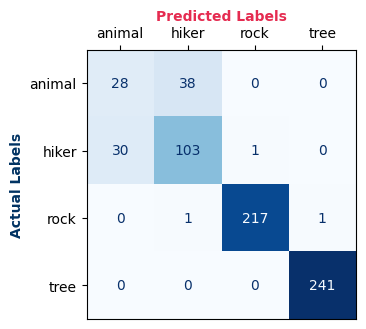

In [ ]:
# import ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# define an Axes and figure
fig, ax = plt.subplots(figsize=(3.5, 3.5))

# ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        cmap='Blues',
                                        colorbar=False,
                                        ax = ax)

# modify label appearance
ax.set_ylabel('Actual Labels', weight='black', color='#003262')
ax.set_xlabel('Predicted Labels', weight='black', color='#E52B50')

# move the xaxis ticks and label to top of plot
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

plt.show()

In [ ]:
# distribution of actual labels in test_set:
y_test.value_counts()

label
tree      241
rock      219
hiker     134
animal     66
Name: count, dtype: int64

💡 **Insight**
+ _imbalanced_ datasets are those whose feaures or labels are represented by _disproportional_ number of samples
+ Compared to the distribution of actual labels in the `y_test` dataset, the model seems to perform better on predicting `rocks` and `trees`, but gets confused when predicting `hikers` and `animals`
+ However, due to the dominance of `rocks` and `trees` in the dataset, and minority representation of `hikers` and `animals`, the model's `accuracy_score` remains high.

## Conclusion
+ `accuracy_score` as a metric for evaluating classification models has its shortcomings and should not be used in isolation
+ `confusion_matrix` gives a better visual representation of a classification model's performance